# Amazon Reviews Project
**Author: Yuling Liu**


The dataset used in project is 100,000 Amazon product reviews, including a bag of words model, a dictionary, a column of datetimes, and star ratings. The aim is to predict star ratings (1-5).



### 1. Import package





In [0]:
%%capture
!pip install -U gensim
!pip install urllib2
import gensim
gensim.__version__
# import stuff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from gensim import corpora
from gensim.models import LsiModel, KeyedVectors
from gensim.models.tfidfmodel import TfidfModel
from gensim.models.nmf import Nmf

import sklearn.model_selection as ms
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from statsmodels.tsa.stattools import adfuller

from datetime import *
from operator import itemgetter

import nltk
from nltk import classify
from nltk import NaiveBayesClassifier
from nltk.stem import PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

from xgboost import XGBClassifier

from sklearn import svm

from sklearn.linear_model import LogisticRegression

from sklearn import metrics

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from sklearn.metrics import classification_report

from statsmodels.tsa.stattools import adfuller

In [0]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf

In [0]:
%%capture
!wget https://cis.upenn.edu/~cis545/data/reviews.dict
!wget https://cis.upenn.edu/~cis545/data/train_reviews.mm
!wget https://cis.upenn.edu/~cis545/data/train_times.npy

### 2. Download dataset

In [0]:
reviews_dict= corpora.Dictionary.load("reviews.dict")
reviews_bow = corpora.MmCorpus('train_reviews.mm')
reviews_times  = np.load('train_times.npy')
reviews_times.shape = (len(reviews_bow),1)
y = np.vstack((np.repeat(1, 4000), np.repeat(2, 4000), np.repeat(3, 4000), np.repeat(4, 4000), np.repeat(5, 4000)))
y = np.repeat(y, 5)

### 3. Useful functions

##### lookup_docs

Convert corpus to list


In [0]:
def lookup_docs(corpus, indices):
  result=[]
  count=0
  for doc in corpus:
    if count in sorted(indices):
      result.append(doc)
    count+=1
  return result

In [0]:
indices = list(range(0, 100000))
docs = lookup_docs(reviews_bow, indices)

##### translate_review

Make reviews readable by combing the index of each word in the dictionary with the word in dictionary


In [0]:
def translate_review(review, reviews_dict):
    result=[]
    for elem in review:
      for i in range(int(elem[1])):  
        result.append(reviews_dict[elem[0]])
    return ', '.join(result).replace(",", "")

##### convert_times

Convert original times to timestamps

In [0]:
def convert_times(reviews_times):
  vfunc=np.vectorize(datetime.fromtimestamp)
  return pd.DataFrame(vfunc(reviews_times)).squeeze()

In [46]:
converted_times = convert_times(reviews_times)
print("converted_times is a", type(converted_times))
converted_times

converted_times is a <class 'pandas.core.series.Series'>


0       2012-05-06
1       2014-04-07
2       2012-07-17
3       2014-07-14
4       2013-05-16
           ...    
99995   2013-04-04
99996   2010-09-21
99997   2013-05-12
99998   2013-03-05
99999   2012-07-27
Name: 0, Length: 100000, dtype: datetime64[ns]

##### make_tfidf

Convert word count to tfidf

In [0]:
def make_tfidf(reviews_bow):
  model=gensim.models.tfidfmodel.TfidfModel(corpus=reviews_bow, normalize=True)
  return model[reviews_bow]
reviews_tfidf = make_tfidf(reviews_bow)
result_doc=lookup_docs(reviews_tfidf, indices)

##### densify

Make the original dataset densified

In [0]:
def densify(sparse, columns):
  result=[]
  for lst in sparse:
    count=0
    tmp=[]
    for j in range(len(lst)):
      if lst[j][0]==count:
        tmp.append(float(lst[j][1]))
        count+=1
      else:
        while(lst[j][0]!=count):
          tmp.append(0)
          count+=1
        tmp.append(lst[j][1])
        count+=1
    result.append(tmp)
  for n in range(len(result)):
    for z in range(columns-len(result[n])):
      result[n].append(0)
  return (np.array(result))

### 4. Random Forest with original dataset (Baseline, accuracy 0.7972)

I used Random Forest as the baseline

##### Train model

In [0]:
def evaluate_model(X, review_times, y):
    X = np.hstack((X, review_times))
    X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state = 1911)
    rfor = RandomForestClassifier(n_estimators=70, random_state=1911)
    rfor.fit(X_train, y_train)
    pred=rfor.predict(X_test)
    return metrics.accuracy_score(y_test, pred), y_test, pred

In [0]:
def evaluate_cutoffs(X_orig, X_dict, X_times, y, cutoffs):
    results = []
    for cutoff in cutoffs:
        np.random.seed(1911)
        model=LsiModel(X_orig, num_topics=cutoff, id2word=X_dict)
        trans=model[X_orig]   # right singular vectors
        dense_trans=densify(trans, cutoff)
        results.append(evaluate_model(dense_trans, X_times, y)[0])
        y_true = evaluate_model(dense_trans, X_times, y)[1]
        y_pred = evaluate_model(dense_trans, X_times, y)[2]
        target_names = ['1 star', '2 stars', '3 stars', '4 stars', '5 stars']
        print(metrics.classification_report(y_true, y_pred, target_names=target_names))
    return results

##### Result

In order to see how the accuracy is like for each star rating, I also printed out the classification report.

It seems like 1 star has the best accuracy. The accuracy 3-5 stars' ratings is lower. 


The result is around 0.7972

In [51]:
results = evaluate_cutoffs(reviews_tfidf, reviews_dict, reviews_times, y, range(37,38))
display(results)

              precision    recall  f1-score   support

      1 star       0.91      0.80      0.85      3951
     2 stars       0.83      0.81      0.82      4040
     3 stars       0.78      0.87      0.82      3989
     4 stars       0.73      0.73      0.73      4006
     5 stars       0.76      0.77      0.77      4014

    accuracy                           0.80     20000
   macro avg       0.80      0.80      0.80     20000
weighted avg       0.80      0.80      0.80     20000



[0.7972]

### 5. Random Forest with changed weights (accuracy 0.79115)


If I can get the most important words (most frequent words maybe?) and add their weights manually, would the results be better? 

##### Finding the most frequent words

In [0]:
def most_freq_words(docs, start, end):
  word={}
  for llst in docs[start:end]:
    for ttup in llst:
      if ttup[0] not in word:
        word[ttup[0]]=ttup[1]
      else:
        word[ttup[0]]+=ttup[1]


  word_max=[(k, word[k]) for k in sorted(word, key=word.get, reverse=True)]

  wd_max=[]
  wd_max_freq=[]
  for elem in word_max[0:30]:
    wd_max.append( (reviews_dict[elem[0]]) )
    wd_max_freq.append(elem[1])
  return wd_max, wd_max_freq

most_one=most_freq_words(docs, 0, 20000)
most_two=most_freq_words(docs, 20000, 40000)
most_three=most_freq_words(docs, 40000, 60000)
most_four=most_freq_words(docs, 60000, 80000)
most_five=most_freq_words(docs, 80000, 100000)

most_bad=most_freq_words(docs, 0, 40000)
most_good=most_freq_words(docs, 60000, 100000)

#for 1 star, maybe like is dislike? no way to know
#maybe add negative weight to ones with words like dog cat??

##### Where are the data coming from?

Given the output of the most frequent words of each star rating, it seems like data of **star rating 1** are from **pet food**, **star rating 2** are from **baby products**, **star rating 3** are from **shoes**, **star rating 4** are from **kitchen products**, **star rating 5** are from clearning products.

In [53]:
#convert frequent words into dataframe
freq_word_df=pd.DataFrame(
    {'1 star': most_one[0],
     '2 stars': most_two[0],
     '3 stars': most_three[0],
     '4 stars': most_four[0],
     '5 stars': most_five[0]
    })
freq_word_df

,1 star,2 stars,3 stars,4 stars,5 stars
0,dog,use,size,use,use
1,cat,babi,like,one,product
2,one,one,look,like,like
3,like,like,fit,get,one
4,use,get,wear,work,work
5,get,just,shoe,just,get
6,just,can,just,will,just
7,will,work,one,good,tri
8,food,seat,order,can,good
9,product,love,will,well,will


In [54]:
#convert best (4-5 stars) and worst (1-2 stars) to dataframe
worst_best_df=pd.DataFrame(
    {'best ratings (4-5 stars)': most_good[0],
     'worst ratings (1-2 stars)': most_bad[0]
    })
worst_best_df

,best ratings (4-5 stars),worst ratings (1-2 stars)
0,use,use
1,one,one
2,like,like
3,work,dog
4,get,get
5,product,just
6,just,can
7,will,babi
8,good,cat
9,can,work


##### Frequency of worst ratings (1-2 stars)

Since each star rating is coming from a specific product, the results are not what I expected. 

I would assume that bad ratings have a lot of bad descriptions so ther would be many negative words in the reviews. However, in this case, it might be more useful to only extract the adjectives to see which words are really more important. I will do that in the next step.

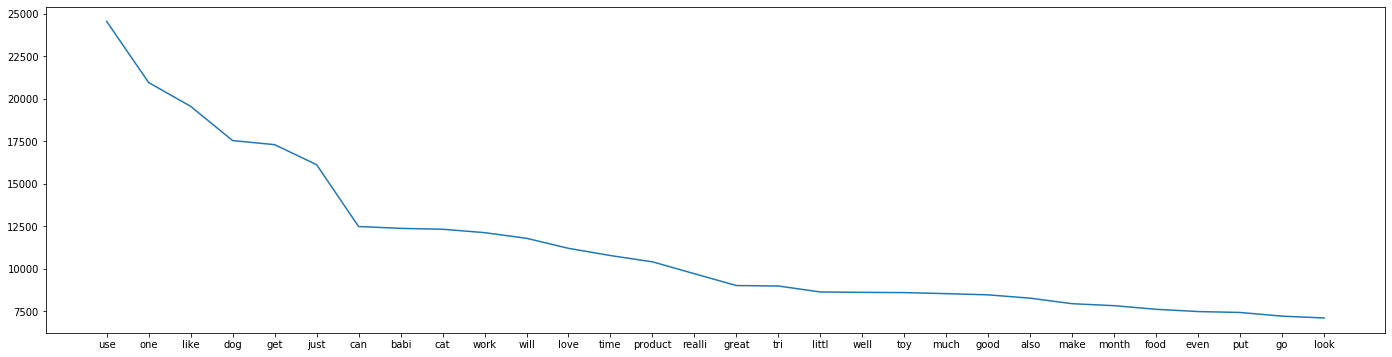

In [55]:
fig_bad=plt.plot(most_bad[0], most_bad[1])
fig_bad=plt.gcf()
fig_bad.set_size_inches(24, 6) 

##### Frequency of best ratings (4-5 stars)

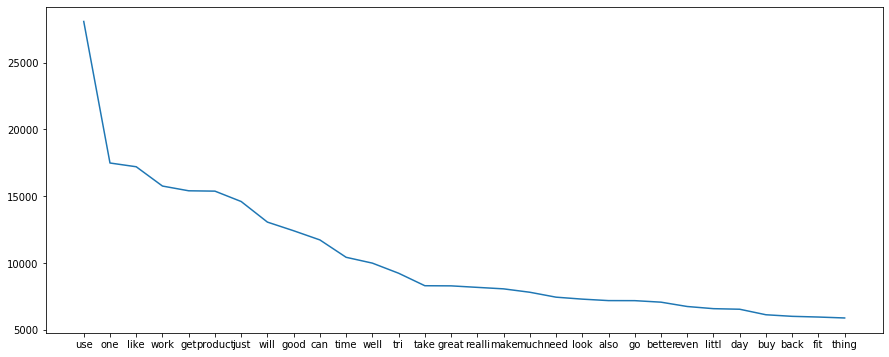

In [56]:
fig_good=plt.plot(most_good[0], most_good[1])
fig_good=plt.gcf()
fig_good.set_size_inches(15, 6)

##### Changing the weights of the words of worst ratings and best ratings 

In [57]:
same_words=[]
for word in most_good[0]:
  for word2 in most_bad[0]:
    if word==word2:
      same_words.append(word)
same_words


only_good=[]
for word3 in most_good[0]:
  if word3 not in same_words:
    only_good.append(word3)

print(only_good)

only_bad=[]
for word4 in most_bad[0]:
  if word4 not in same_words:
    only_bad.append(word4)

print(only_bad)

def getID(words):
  result=[]
  for word in words:
    result.append(reviews_dict.token2id[word])
  return result

only_good_id=getID(only_good)
only_bad_id=getID(only_bad)
print(only_good_id)
print(only_bad_id)

['take', 'need', 'better', 'day', 'buy', 'back', 'fit', 'thing']
['dog', 'babi', 'cat', 'love', 'toy', 'month', 'food', 'put']
[177, 275, 7, 58, 329, 325, 625, 233]
[60, 1505, 266, 486, 50, 171, 315, 70]


I tried weights like +0.2, +0.8, +1, +10 and found that +0.8 weights of these frequent words has the best results. 

In [58]:
0print(result_doc[0])
def increase_weight(docs):
  result=[]
  for lst in docs:
    tmp=[]
    for tup in lst:
      if tup[0] in [19, 20, 420, 492, 85, 852, 277, 169, 1692]:
      #if (tup[0] in only_bad_id) or (tup[0] in only_good_id):
        tmp.append((tup[0], tup[1]+0.8))
      else:
        tmp.append((tup[0], tup[1]))
    result.append(tmp)
  return result

result_doc=increase_weight(result_doc)
print(result_doc[0])

[(0, 0.0660034180373639), (1, 0.12360093748348407), (2, 0.0407796613402426), (3, 0.15992050393599033), (4, 0.15541949979737957), (5, 0.06403024792327237), (6, 0.4183486031794299), (7, 0.045007373378449185), (8, 0.18913727393566332), (9, 0.06641339282532265), (10, 0.10413115494146216), (11, 0.10825486685420439), (12, 0.15525820361308584), (13, 0.06519736368026895), (14, 0.2067794919463751), (15, 0.06590094883325925), (16, 0.1158324947414227), (17, 0.08493483571495053), (18, 0.08755539750744058), (19, 0.0338354240398617), (20, 0.03669439920511), (21, 0.057670953991595504), (22, 0.07051020376459982), (23, 0.028157675316733372), (24, 0.44250466469710886), (25, 0.06111733364998563), (26, 0.17050232085388733), (27, 0.07454444489391773), (28, 0.040576679631273434), (29, 0.17164557258925867), (30, 0.08175891731909864), (31, 0.05823720551567898), (32, 0.039456211128453836), (33, 0.062362256150244405), (34, 0.20042926732827837), (35, 0.06911419139133088), (36, 0.07004236227439306), (37, 0.085128

##### Train model

In [0]:
def evaluate_model(X, review_times, y):
    X = np.hstack((X, review_times))
    X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state = 1911)
    rfor = RandomForestClassifier(n_estimators=70, random_state=1911)
    rfor.fit(X_train, y_train)
    pred=rfor.predict(X_test)
    return metrics.accuracy_score(y_test, pred)

def evaluate_cutoffs(X_orig, X_dict, X_times, y, cutoffs):
    results = []
    for cutoff in cutoffs:
        np.random.seed(1911)
        model=LsiModel(X_orig, num_topics=cutoff, id2word=X_dict)
        trans=model[X_orig]   # right singular vectors
        dense_trans=densify(trans, cutoff)
        results.append(evaluate_model(dense_trans, X_times, y))
    return results

##### Result

In [60]:
results=evaluate_cutoffs(result_doc, reviews_dict, reviews_times, y, range(39,40))
display(results)

[0.79115]

The result is not as good as the original one. I think the reason is that tfidf already computes the relative importance of each word so there' s no need to change the weights manually.

### 6. Random Forest with adjectives (accuracy 0.4625)

Adjectives are important for star ratings classification since words like "good", "bad", "best", "terrible" clearly indicate the preference of the users. As a result, I filtered out only adjectives and used them to predict star ratings.

###### Get adjectives

In [0]:
def get_adj(docs):
  adj_result=[]
  for doc in docs:
    wo=[]
    words=[]
    for tup in doc:
      words.append(reviews_dict[tup[0]])
    tag=nltk.pos_tag(words)
    for i in range(len(tag)):
      if tag[i][1]=="JJ":
        wo.append(doc[i])
    adj_result.append(wo)
  return adj_result

adj_docs=get_adj(result_doc)

###### Train model

In [0]:
from sklearn import metrics
def evaluate_model_adj(X, review_times, y):
    X = np.hstack((X, review_times))
    X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state = 1911)
    rfor = RandomForestClassifier(n_estimators=70, random_state=1911)
    rfor.fit(X_train, y_train)
    pred=rfor.predict(X_test)
    return metrics.accuracy_score(y_test, pred)

def evaluate_cutoffs(X_orig, X_dict, X_times, y, cutoffs):
    results = []
    for cutoff in cutoffs:
        np.random.seed(1911)
        model=LsiModel(X_orig, num_topics=cutoff, id2word=X_dict)
        trans=model[X_orig]   # right singular vectors
        dense_trans=densify(trans, cutoff)
        results.append(evaluate_model_adj(dense_trans, X_times, y))
    return results

##### Result

The results are not ideal comparing to the baseline. I think this suggest that the model relies heavily on keywords like "dog", "food", "baby" and such. 

If we fit the model to predict a general dataset, the gerenalization will be very bad if the model relies on keywords of type of products too much.

In [63]:
results=evaluate_cutoffs(adj_docs, reviews_dict, reviews_times, y, range(60,61))
display(results)

[0.4265]

### 7. Support Vector Machine (Accuracy 0.19945)

I want to show that choosing the right classification model is important. 

Random Forest is intrinsically suited for multiclass problems, while SVM is intrinsically two-class. For multiclass problem we need to reduce it into multiple binary classification problems. 

As a result, since there are 5 classes, the result will be aroun 0.2.

##### Train model

In [0]:
def evaluate_model_SVR(X, review_times, y):
    X = np.hstack((X, review_times))
    X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state = 1911)
    rfor = svm.LinearSVC()
    rfor.fit(X_train, y_train)
    pred=rfor.predict(X_test)
    return metrics.accuracy_score(y_test, pred)

# answer 3.2
# TODO: Complete the function
def evaluate_cutoffs(X_orig, X_dict, X_times, y, cutoffs):
    results = []
    for cutoff in cutoffs:
        np.random.seed(1911)
        model=LsiModel(X_orig, num_topics=cutoff, id2word=X_dict)
        trans=model[X_orig]   # right singular vectors
        dense_trans=densify(trans, cutoff)
        results.append(evaluate_model_SVR(dense_trans, X_times, y))
    return results

##### Result

In [68]:
results=evaluate_cutoffs(result_doc, reviews_dict, reviews_times, y, range(37,38))
display(results)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[0.19945]

### 8. XGBoost (accuracy 0.792)

XGBoost has many advantages:
* XGBoost has in-built L1 and L2 regularization which prevents the model from overfitting, and thus is better other GBM (Gradient Boosting Machine).
* A GBM would stop splitting a node when it encounters a negative loss in the split. Thus it is more of a greedy algorithm. XGBoost on the other hand make splits upto the max_depth specified and then start pruning the tree backwards and remove splits beyond which there is no positive gain.

Given its advantages, I decided to use XGBoost as my classifier.

##### Train model

In [0]:
def evaluate_model_XG(X, review_times, y, learning_rate):
    X = np.hstack((X, review_times))
    X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state = 1911)
    rfor = XGBClassifier(random_state=1911, learning_rate=learning_rate)
    rfor.fit(X_train, y_train)
    pred=rfor.predict(X_test)
    return metrics.accuracy_score(y_test, pred)

def evaluate_cutoffs(X_orig, X_dict, X_times, y, cutoffs, learning_rate):
    results = []
    for cutoff in cutoffs:
        np.random.seed(1911)
        model=LsiModel(X_orig, num_topics=cutoff, id2word=X_dict)
        trans=model[X_orig]   # right singular vectors
        dense_trans=densify(trans, cutoff)
        results.append(evaluate_model_XG(dense_trans, X_times, y, learning_rate))
    return results

##### Result

I tried learning rate of 0.1, 0.2 0.25, 0.3 to figure out the best learning rate and turns out it is 0.25. The result is not much different from Random Forest.

In [66]:
for learning_rate in [0.1, 0.2, 0.25, 0.3]:
  results=evaluate_cutoffs(result_doc, reviews_dict, reviews_times, y, range(37,38), learning_rate)
  display(results)

[0.7747]

[0.7875]

[0.7902]

[0.792]

### 9. Multi-layer Perceptron (**Best Model**, accuracy 0.80055)

Since the data is tabular, Random Forest would work well. Neural Network would work on any data type, so this should work well too.

##### Train model

In [0]:
def evaluate_model_MLP(X, review_times, y):
    X = np.hstack((X, review_times))
    X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state = 1911)
    scaler = StandardScaler() 
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    rfor = MLPClassifier(hidden_layer_sizes=(10,))
    rfor.fit(X_train, y_train)
    pred=rfor.predict(X_test)
    return metrics.accuracy_score(y_test, pred)

def evaluate_cutoffs_MLP(X_orig, X_dict, X_times, y, cutoffs):
    results = []
    for cutoff in cutoffs:
        np.random.seed(1911)
        model=LsiModel(X_orig, num_topics=cutoff, id2word=X_dict)
        trans=model[X_orig]   # right singular vectors
        dense_trans=densify(trans, cutoff)
        results.append(evaluate_model_MLP(dense_trans, X_times, y))
    return results

##### Result

In [75]:
results=evaluate_cutoffs_MLP(result_doc, reviews_dict, reviews_times, y, range(37,39))
display(results)

[0.79775, 0.80055]

### Linear Regression (accuracy 0.4549)

Although I don't think the results will be better, I wanted to see if this problem can be treated as a regrssion problem vs a classification problem.

##### Train model

In [0]:
from sklearn.linear_model import LinearRegression
def evaluate_model_LR(X, review_times, y):
    X = np.hstack((X, review_times))
    X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state = 1911)
    lr = LinearRegression()
    model = lr.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return model.score(X_test, y_test)


def evaluate_cutoffs_LR(X_orig, X_dict, X_times, y, cutoffs):
  results = []
  for cutoff in cutoffs:
    model = LsiModel(X_orig, num_topics = cutoff, id2word = X_dict)
    projection = model[X_orig]
    proj_dense = densify(projection, cutoff)
    results.append(evaluate_model_LR(proj_dense, X_times, y))
    np.random.seed(1911)
  return results

##### Result

This problem has better results if treated as a classification model.

In [77]:
results=evaluate_cutoffs_LR(result_doc, reviews_dict, reviews_times, y, range(37,38))
display(results)

[0.4549441351246157]

### 11. Time Series

Since there might be a trend with timestamp that can help predict the star ratings, I chose to use time series to predict star ratings.

##### Extract time and star ratings

Now we have a times series of timestamp and star ratings.

In [78]:
data_df=pd.DataFrame(list(zip(converted_times, y)))
data_df.columns=['timestamp', 'star']
ts=pd.Series(data_df['star'].values, index=data_df['timestamp'])
ts

timestamp
2012-05-06    1
2014-04-07    1
2012-07-17    1
2014-07-14    1
2013-05-16    1
             ..
2013-04-04    5
2010-09-21    5
2013-05-12    5
2013-03-05    5
2012-07-27    5
Length: 100000, dtype: int64

##### Check Stationarity

Since most of the Time Series models work on the assumption that the Time Series is stationary, I checked if this data is stationary. 


First and foremost is to simple plot the data and analyze visually. I grouped the data by **month** to make the plot clearer. 

According to the plot, it is clearly evident that there is an overall increasing trend in the data.

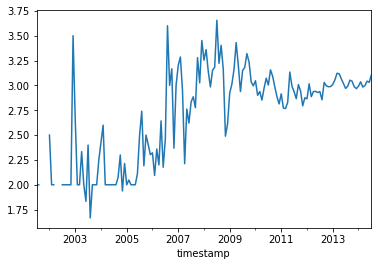

In [79]:
ts_mean=ts.resample('M').mean()
ts_mean
ts_mean.plot()
#it's not stationary

However, it might not always be possible to make such visual inferences. So, more formally, I decided to check stationarity using Dickey-Fuller Test.

Here the null hypothesis is that the Time Series is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.

I applied Dickey-Fuller test results on the original time series dataset and drew the rolling statistics plots with the times series grouped by year.

In [0]:
def plot_stationary(timeseries):
  rolmean=pd.Series.rolling(timeseries, center=False, window=2).mean()
  rolstd=pd.Series.rolling(timeseries, center=False, window=2).std()
  orig=plt.plot(timeseries, color='blue', label='Original')
  mean=plt.plot(rolmean, color='red', label='Rolling Mean')
  std=plt.plot(rolstd, color='black', label='Rolling Std')
  plt.legend(loc='best')
  plt.title('Rolling Mean & Standard Deviation')
  plt.show(block=False)

def test_stationarity(timeseries):
  print('Results of Dickey-Fuller Test: ')
  dftest=adfuller(timeseries, autolag='AIC')
  dfoutput=pd.Series(dftest[0:4], 
                   index=['Test Statistic', 'p-value', '#Lags Used','Number of Obervations Used'])
  for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'% key]=value
  print(dfoutput)

Though the variation in standard deviation is small, mean is clearly increasing with time and this is not a stationary series. 

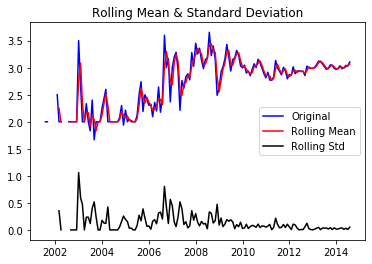

Results of Dickey-Fuller Test: 
Test Statistic                   -0.707091
p-value                           0.844904
#Lags Used                        0.000000
Number of Obervations Used    99999.000000
Critical Value (1%)              -3.430415
Critical Value (5%)              -2.861569
Critical Value (10%)             -2.566785
dtype: float64


In [81]:
plot_stationary(ts_mean)
test_stationarity(ts)

We cannot reject the null hypothesis (non-stationary) since p value>0.05.
Thus is is probabily a non-stationary series.

##### Make the time series stationary

Before we apply any model to predict star ratings, we need to make the time series stationary. While there are many options to achieve the result, I began by choosing to transform the time series by **taking log**, which penalizes higher values more than smaller ones.


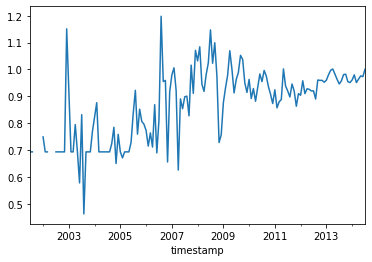

In [82]:
ts_log=np.log(ts)
ts_log_mean=ts_log.resample('M').mean()
ts_log_mean.plot()

Taking log doesn't seem to make the time series stationary. To furthur confirm, I applied the Dickey-Fuller test.

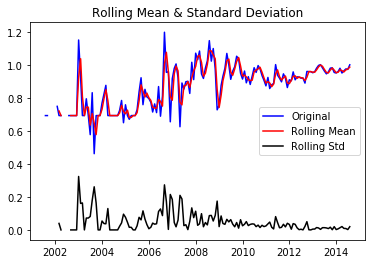

Results of Dickey-Fuller Test: 
Test Statistic                   -1.266204
p-value                           0.644489
#Lags Used                        0.000000
Number of Obervations Used    99999.000000
Critical Value (1%)              -3.430415
Critical Value (5%)              -2.861569
Critical Value (10%)             -2.566785
dtype: float64


In [83]:
plot_stationary(ts_log_mean)
test_stationarity(ts_log)

The time series is not stationary yet. Thus, I took the difference with a particular time lag by using **moving average** on log time series.


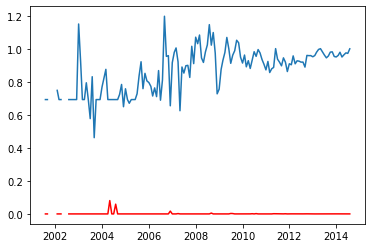

In [84]:
moving_avg=pd.Series.rolling(ts_log, center=False, window=30).mean()
ts_log_moving_avg_diff=ts_log-moving_avg
ts_log_moving_avg_diff.dropna(inplace=True)
ts_log_moving_avg_diff_mean=ts_log_moving_avg_diff.resample('M').mean()
plt.plot(ts_log_mean)
plt.plot(ts_log_moving_avg_diff_mean, color='red')

Comparing with log time series, log moving average difference time series seems much more stationary. To confirm, I applied the test.

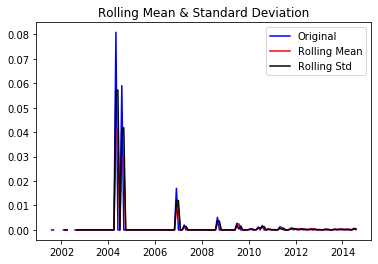

Results of Dickey-Fuller Test: 
Test Statistic                  -42.391480
p-value                           0.000000
#Lags Used                       35.000000
Number of Obervations Used    99935.000000
Critical Value (1%)              -3.430415
Critical Value (5%)              -2.861569
Critical Value (10%)             -2.566785
dtype: float64


In [85]:
plot_stationary(ts_log_moving_avg_diff_mean)
test_stationarity(ts_log_moving_avg_diff)

We can reject the null hypothesis that the time series is not stationary with a p-value <0.005. **ts_log_moving_avg_diff** is **stationary**. Just for comparison, I tried another method to make the time series stationary- **Exponentially weighted moving average**.

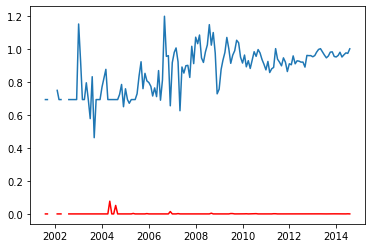

In [86]:
expweighted_avg=pd.Series.ewm(ts_log, ignore_na=False,
                              adjust=True, halflife=12, min_periods=0).mean()
ts_log_ewma_diff=ts_log-expweighted_avg
ts_log_ewma_diff_mean=ts_log_ewma_diff.resample('M').mean()
plt.plot(ts_log_mean)
plt.plot(ts_log_ewma_diff_mean, color='red')

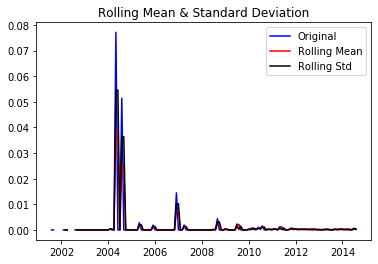

Results of Dickey-Fuller Test: 
Test Statistic                  -53.764822
p-value                           0.000000
#Lags Used                        0.000000
Number of Obervations Used    99999.000000
Critical Value (1%)              -3.430415
Critical Value (5%)              -2.861569
Critical Value (10%)             -2.566785
dtype: float64


In [87]:
plot_stationary(ts_log_ewma_diff_mean)
test_stationarity(ts_log_ewma_diff)

Exponentially weighted moving average is again stationary. 

##### Finding p, d, q for ARIMA model

Since we now have stationary time series, it is time to perform Autoregressive Integrated Moving Average (**ARIMA**) model. **ARIMA** can be interpreted as 

* **AR**: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.

* **I**: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.

* ***MA***: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.


But before using the ARIMA model, we need to find the value of **p, d, q**.


*   **p** is the number of lag observations included in the model, also called the lag order.
*   **d** is the number of times that the raw observations are differenced, also called the degree of differencing.
*   **q** is the size of the moving average window, also called the order of moving average.



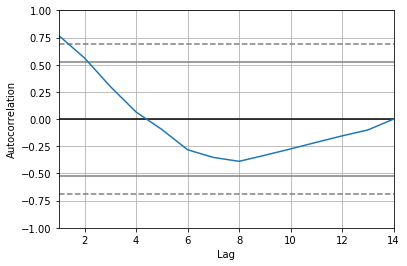

In [88]:
curr=ts.resample("Y").mean()
autocorrelation_plot(curr)

When lag is approximatly 1, the upper confidence interval is crossed. Thus **p is 1**.

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


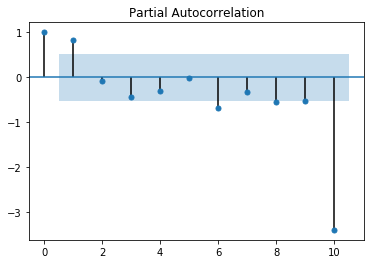

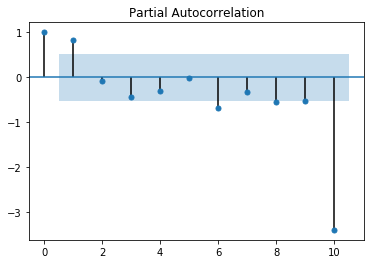

In [117]:
ts_year=ts.resample("Y").mean()
plot_pacf(ts_year, lags=10)

Since there are around 4 lags, **q=4**.

**d=1** since data is differentiated twice to be stationary.

##### Make predictions

I tried to run the model with order (1,1,2), but the result is not stationary. As a result, I ran the ARIMA model with order=(1, 1, 0).



In [122]:
model=ARIMA(ts_log, order=(1,1,0))
results_AR=model.fit(disp=-1)
print(results_AR.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                99999
Model:                 ARIMA(1, 1, 0)   Log Likelihood              446338.558
Method:                       css-mle   S.D. of innovations              0.003
Date:                Wed, 11 Dec 2019   AIC                        -892671.115
Time:                        21:58:05   BIC                        -892642.576
Sample:                             1   HQIC                       -892662.454
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.609e-05   8.82e-06      1.825      0.068   -1.19e-06    3.34e-05
ar.L1.D.y  -3.332e-05      0.003     -0.011      0.992      -0.006       0.006
                                    Roots           

Text(0.5, 1.0, 'RSS: 3471638.7127')

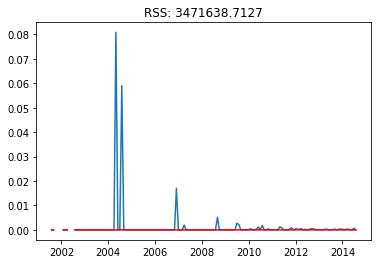

In [123]:
plt.plot(ts_log_moving_avg_diff.resample('M').mean())
plt.plot(results_AR.fittedvalues.resample('M').mean(), color='red')
plt.title('RSS: %.4f' % sum(results_AR.fittedvalues-ts_log_moving_avg_diff)**2)

Taking values back to original scale to see how well we are forecasting.

In [124]:
predictions_ARIMA_diff=pd.Series(results_AR.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

timestamp
2014-04-07    0.000016
2012-07-17    0.000016
2014-07-14    0.000016
2013-05-16    0.000016
2013-06-17    0.000016
dtype: float64

Take cumulative sum as index

In [125]:
predictions_ARIMA_diff_cumsum=predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

timestamp
2014-04-07    0.000016
2012-07-17    0.000032
2014-07-14    0.000048
2013-05-16    0.000064
2013-06-17    0.000080
dtype: float64

Add to ts_log, taking index position differences into account

In [126]:
predictions_ARIMA_log=pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


timestamp
2012-05-06    0.0
2014-04-07    0.0
2012-07-17    0.0
2014-07-14    0.0
2013-05-16    0.0
dtype: float64

In [127]:
predictions_ARIMA_log=predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

timestamp
2001-07-17    0.556169
2001-07-25    0.530289
2001-08-24    0.426686
2002-01-01    1.577056
2002-01-05    0.081456
dtype: float64

Take the exponent and compare with the original series

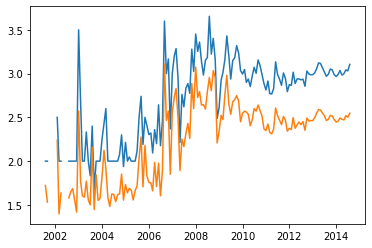

In [128]:
predictions_ARIMA=np.exp(predictions_ARIMA_log)
plt.plot(ts_mean)
plt.plot(predictions_ARIMA.resample('M').mean())